# One Class Support Vector Machines

## Importing Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [2]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [3]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [4]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [5]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

In [14]:
#fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
#fig.set_facecolor("white")

train_end = 5760
shift = 2*360 # since the period is 6 hours (360) and we do this twice

# LISTS
# First anomalies after infection
min_scores = []
first_anom_train = []
first_anom_inf = []
score_train = []
score_infec = []
tpr = []

for i in range(0, df_temp.shape[1]): #df_temp.shape[1]
    #ax[0].cla()  # clear axis 0-1
    #ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    ##################################################################
    # Finding Infection Time
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
        ##################################################################
        # Filing in missing data
        temp_value_fw = temp_value.fillna(method='ffill') # foward fill
        temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill

        # Time Delay Embedding
        temp_tde = tde.tde(temp_value_bw) # using the tde file
        temp_tde = temp_tde.T # transporting the data

        ##################################################################
        # Fit the Data on the first 3 days (3*24*60) 
        model.fit(temp_tde[:train_end+1,:])

        # Predict the Data
        predict_train_data = model.predict(temp_tde[:train_end+1,:]) # predict on training data
        predict_test_data = model.predict(temp_tde[train_end+1:,:]) # predicting on test data

        # Scores
        scores_train_data = model.score_samples(temp_tde[:train_end+1,:]) # scores on training data 
        scores_test_data = model.score_samples(temp_tde[train_end+1:,:]) # scores on test data

        threshold = model.offset_

        ##################################################################
        # Combine training and testing scores and predictions
        combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
        combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)

        time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift

        # Minimum score
        min_score = scores_train_data.min()

        # Find the indices of the anomalies
        anomaly_indices = np.where(combined_scores <= min_score)[0] #finding the values where its -1 (anomaly)
        time_2 = anomaly_indices + (shift) # shifting the time for plotting
        
        ##################################################################
        # Find the index at which the first score is less than min_score
        boolean = combined_scores < min_score
        anom_train = np.argmax(boolean) #+shift
        anom_infec = np.argmax(boolean[infection_time-shift:]) + infection_time 

        # Get the corresponding value
        value = combined_scores[anom_train]
        value_1 = combined_scores[anom_infec-shift]

        # Calculating the time first anomaly was found after training and infection
        time_aft_train = (anom_train + shift) - train_end
        time_aft_infection = anom_infec - infection_time

        # Calculating the amount of false negatives (between end of train and infection time)
        count_false_neg = np.count_nonzero(boolean[train_end:infection_time])

        # Calculating the amount of true positives (infection time)
        count_true_pos = np.count_nonzero(boolean[infection_time:]) 

        # Calculating true positive rate
        # Check if the denominator is zero
        if (count_true_pos + count_false_neg) == 0:
            print("N/A")
            continue  # Skip this iteration and move to the next number
        TPR = count_true_pos / (count_true_pos + count_false_neg)
        
        ##################################################################
        # Print Values
        print("Minimum Score: ", min_score)
        print("After Training Min: ", anom_train+shift)
        print("After Infection Min: ", anom_infec)
        print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
        print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
        print(f"True Positve Rate: {TPR*100}%")

        ##################################################################
        # Appending to Lists
        min_scores.append(min_score)
        first_anom_train.append(time_aft_train)
        first_anom_inf.append(time_aft_infection)
        score_train.append(value)
        score_infec.append(value_1)
        tpr.append(TPR)
    
    else:
        print(f"No match found for mouse '{names}'")
   

Found 'CC006-315' and its infection value is '10300'
Minimum Score:  349.54576079540476
After Training Min:  11048
After Infection Min:  11048
First anomaly found after training: 5288 minutes with score 345.7153275046626
First anomaly found after infection: 748 minutes with score 345.7153275046626
True Positve Rate: 100.0%
Found 'CC006-316' and its infection value is '10300'
Minimum Score:  368.954491866093
After Training Min:  6949
After Infection Min:  10463
First anomaly found after training: 1189 minutes with score 363.84915270259853
First anomaly found after infection: 163 minutes with score 320.3102136970141
True Positve Rate: 98.43221641561635%
Found 'CC006-317' and its infection value is '10300'
Minimum Score:  387.14532068752135
After Training Min:  6702
After Infection Min:  12657
First anomaly found after training: 942 minutes with score 381.9142879271862
First anomaly found after infection: 2357 minutes with score 381.9227896952819
True Positve Rate: 99.84514796971783%
Foun

Minimum Score:  182.55863723085486
After Training Min:  16322
After Infection Min:  16322
First anomaly found after training: 10562 minutes with score 179.23874018029824
First anomaly found after infection: 2122 minutes with score 179.23874018029824
True Positve Rate: 100.0%
Found 'CC002-558' and its infection value is '14200'
Minimum Score:  281.77907638035896
After Training Min:  6801
After Infection Min:  14559
First anomaly found after training: 1041 minutes with score 273.5688380264279
First anomaly found after infection: 359 minutes with score 281.3892007560289
True Positve Rate: 97.8988411133976%
Found 'CC002-559' and its infection value is '14200'
Minimum Score:  168.11919387184656
After Training Min:  7008
After Infection Min:  14579
First anomaly found after training: 1248 minutes with score 162.1902677909577
First anomaly found after infection: 379 minutes with score 161.09534396480717
True Positve Rate: 6.081081081081082%
Found 'CC015-390' and its infection value is '14200'

Minimum Score:  299.5481101279245
After Training Min:  7558
After Infection Min:  12292
First anomaly found after training: 1798 minutes with score 297.5781063765646
First anomaly found after infection: 992 minutes with score 294.4043359465075
True Positve Rate: 99.9722556182373%
No match found for mouse 'CC015-442'
No match found for mouse 'CC024-361'
Found 'CC024-362' and its infection value is '11300'
Minimum Score:  270.1036277851412
After Training Min:  6850
After Infection Min:  18600
First anomaly found after training: 1090 minutes with score 256.87631620403386
First anomaly found after infection: 7300 minutes with score 264.0046193138012
True Positve Rate: 60.35502958579882%
Found 'CC025-598' and its infection value is '11300'
Minimum Score:  349.4136294156354
After Training Min:  6714
After Infection Min:  11300
First anomaly found after training: 954 minutes with score 336.2964615783546
First anomaly found after infection: 0 minutes with score 782.6592396882132
True Positve R

N/A
Found 'CC005-411' and its infection value is '14300'
Minimum Score:  258.2968276805031
After Training Min:  14366
After Infection Min:  14366
First anomaly found after training: 8606 minutes with score 257.89727036547765
First anomaly found after infection: 66 minutes with score 257.89727036547765
True Positve Rate: 94.27083333333334%
Found 'CC019-1445' and its infection value is '14300'
Minimum Score:  139.46015419248408
After Training Min:  7013
After Infection Min:  22055
First anomaly found after training: 1253 minutes with score 124.00201834718257
First anomaly found after infection: 7755 minutes with score 136.66628271718025
True Positve Rate: 44.230769230769226%
Found 'CC019-1451' and its infection value is '14300'
Minimum Score:  233.0366427026321
After Training Min:  7483
After Infection Min:  14344
First anomaly found after training: 1723 minutes with score 220.0211071897827
First anomaly found after infection: 44 minutes with score 207.76681825431808
True Positve Rate: 8

Minimum Score:  367.20029691522313
After Training Min:  7448
After Infection Min:  10319
First anomaly found after training: 1688 minutes with score 355.12977004742754
First anomaly found after infection: 69 minutes with score 338.7485426514347
True Positve Rate: 99.52822515047991%
No match found for mouse 'C57Bl6-104'
Found 'C57Bl6-105' and its infection value is '10000'
Minimum Score:  282.2075969191332
After Training Min:  11456
After Infection Min:  11456
First anomaly found after training: 5696 minutes with score 275.3609131386449
First anomaly found after infection: 1456 minutes with score 275.3609131386449
True Positve Rate: 100.0%
Found 'C57Bl6-106' and its infection value is '10000'
Minimum Score:  385.9503122496715
After Training Min:  7482
After Infection Min:  11603
First anomaly found after training: 1722 minutes with score 384.4288163594748
First anomaly found after infection: 1603 minutes with score 382.0114915460563
True Positve Rate: 91.73047473200613%
Found 'CC019-151

Minimum Score:  20.49906382638858
After Training Min:  13328
After Infection Min:  13328
First anomaly found after training: 7568 minutes with score 14.257119536468963
First anomaly found after infection: 3228 minutes with score 14.257119536468963
True Positve Rate: 100.0%
Found 'CC042-348' and its infection value is '10100'
Minimum Score:  208.22203765426514
After Training Min:  6927
After Infection Min:  10647
First anomaly found after training: 1167 minutes with score 172.70208399058572
First anomaly found after infection: 547 minutes with score 204.50349903702852
True Positve Rate: 99.83559069913099%
Found 'CC042-349' and its infection value is '10100'
Minimum Score:  363.58876981003675
After Training Min:  6938
After Infection Min:  19455
First anomaly found after training: 1178 minutes with score 308.7977129324947
First anomaly found after infection: 9355 minutes with score 343.782347491144
True Positve Rate: 87.93103448275862%
Found 'CC043-562' and its infection value is '10100'

In [15]:
# Make all lists into arrays
ms = np.array(min_scores)
fat = np.array(first_anom_train)
fai = np.array(first_anom_inf)
st = np.array(score_train)
si = np.array(score_infec)
tprs = np.array(tpr)

In [16]:
# Create the data for the table (calculates statistics)
data = {
    'column_1': [round(np.mean(ms),2), round(np.mean(fat),2), round(np.mean(fai),2), round(np.mean(st),2), round(np.mean(si),2), round(np.mean(tprs)*100,2)],
    'column_2': [round(np.std(ms),2), round(np.std(fat),2), round(np.std(fai),2), round(np.std(st),2), round(np.std(si),2), round(np.std(tprs)*100,2)],
    'column_3': [round(np.percentile(ms, 25),2), round(np.percentile(fat, 25),2), round(np.percentile(fai, 25),2), round(np.percentile(st, 25),2), round(np.percentile(si, 25),2), round(np.percentile(tprs, 25)*100,2)],
    'column_4': [round(np.percentile(ms, 50),2), round(np.percentile(fat, 50),2), round(np.percentile(fai, 50),2), round(np.percentile(st, 50),2), round(np.percentile(si, 50),2), round(np.percentile(tprs, 50)*100,2)],
    'column_5': [round(np.percentile(ms, 75),2), round(np.percentile(fat, 75),2), round(np.percentile(fai, 75),2), round(np.percentile(st, 75),2), round(np.percentile(si, 75),2), round(np.percentile(tprs, 75)*100,2)]
}

In [17]:
# Create a DataFrame
df = pd.DataFrame(data)

# Set row names (index)
row_names = ['Minimum Score', 'First Anomaly Time After Training', 'First Anomaly Time After Infection', 'First Anomaly Score After Training', 'First Anomaly Score After Infection  ', 'True Positive Rate']
df.index = row_names

# Set column names
column_names = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns = column_names


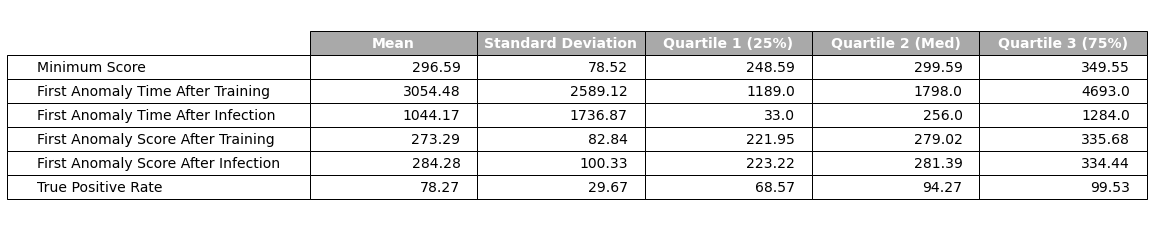

In [18]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns):
    cell = table[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
plt.savefig('table_statistics_4days.png', bbox_inches='tight', facecolor='white')


In [13]:
tpr

[1.0,
 0.9843221641561636,
 0.9984514796971783,
 0.9495268138801262,
 0.9524975514201763,
 0.9807692307692307,
 0.9989860583016477,
 0.9956069859637844,
 0.631578947368421,
 0.9830148619957537,
 0.941702365431179,
 0.9982853223593965,
 0.860655737704918,
 0.5,
 0.8712121212121212,
 0.9976943768412962,
 0.3695652173913043,
 0.9707446808510638,
 0.681145584725537,
 0.9595457771469127,
 0.006369426751592357,
 1.0,
 0.6856829402084477,
 0.9699826989619377,
 1.0,
 0.9789884111339759,
 0.060810810810810814,
 0.425531914893617,
 1.0,
 0.08774038461538461,
 0.9020791415157612,
 0.8023088023088023,
 0.868421052631579,
 0.7408883826879271,
 0.9897959183673469,
 1.0,
 1.0,
 0.9978281397544854,
 0.9795858850976962,
 0.9993936243936244,
 0.9925847457627118,
 0.291044776119403,
 0.043478260869565216,
 0.9947916666666666,
 0.56,
 1.0,
 0.998474945533769,
 1.0,
 0.9959599846094652,
 0.999722556182373,
 0.6035502958579881,
 0.0,
 0.772189349112426,
 0.9195979899497487,
 0.9929683576092416,
 0.166666666